## Nested Logit

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2
import sys

import pymc as pm

sys.path.append("../../../..")

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv("../../../../data/choice_wide_heating.csv")
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


## Single Layer Nesting

In [3]:
## No Fixed Covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": ["hp", "gr", "er"]}


nstL_1 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_1

In [4]:
X, F, y = nstL_1.preprocess_model_data(df, utility_formulas)
print(X.shape)
F

(900, 5, 2)


In [5]:
coords = nstL_1.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': [],
 'nests': ['central', 'room'],
 'obs': range(0, 900)}

In [6]:
nest_indices = nstL_1.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])}}

In [7]:
lambda_lkup = nstL_1.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1}

In [8]:
alternatives = nstL_1.alternatives

In [9]:
nstL_1.make_model(X=X, W=F, y=y)

           alphas ~ Normal(0, 1)
            betas ~ Normal(0, 1)
     lambda_nests ~ Beta(2, 2)
                U ~ Deterministic(f(betas, alphas))
p_y_given_central ~ Deterministic(f(lambda_nests, betas, alphas))
        I_central ~ Deterministic(f(lambda_nests, betas, alphas))
   p_y_given_room ~ Deterministic(f(lambda_nests, betas, alphas))
           I_room ~ Deterministic(f(lambda_nests, betas, alphas))
        denom_top ~ Deterministic(f(lambda_nests, betas, alphas))
        P_central ~ Deterministic(f(lambda_nests, betas, alphas))
           P_room ~ Deterministic(f(lambda_nests, betas, alphas))
   prod_central_t ~ Deterministic(f(lambda_nests, betas, alphas))
      prod_room_t ~ Deterministic(f(lambda_nests, betas, alphas))
                p ~ Deterministic(f(lambda_nests, betas, alphas))
       likelihood ~ Categorical(p)

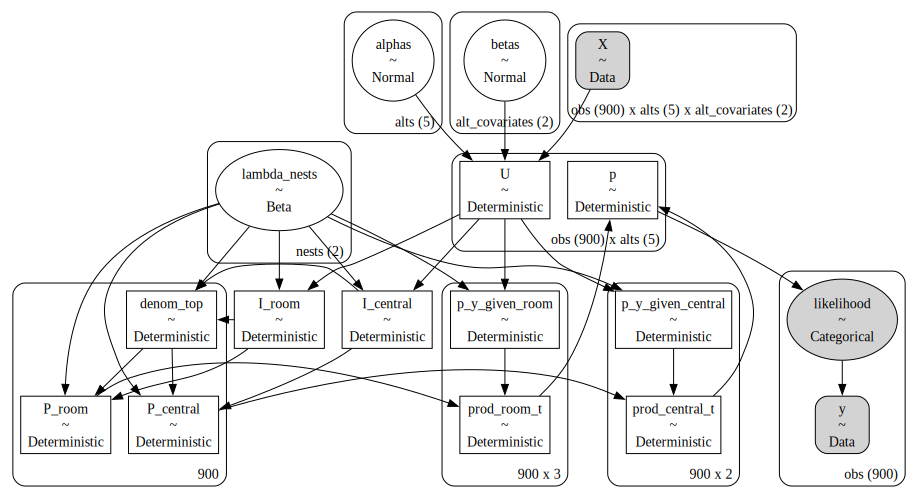

In [10]:
nstL_1.graphviz()

In [11]:
nstL_1.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [12]:
az.summary(nstL_1.idata, var_names=["betas", "alphas", "lambda_nests"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.002,-0.000,0.000,0.000,2501.0,1696.0,1.00
betas[oc],-0.005,0.001,-0.008,-0.003,0.000,0.000,1369.0,2076.0,1.00
alphas[gc],0.008,0.728,-1.355,1.390,0.018,0.013,1569.0,1830.0,1.00
alphas[ec],-0.001,0.738,-1.402,1.355,0.018,0.014,1678.0,1707.0,1.00
alphas[gr],0.079,0.141,-0.191,0.351,0.003,0.003,2878.0,2311.0,1.00
alphas[er],1.308,0.337,0.675,1.919,0.009,0.005,1303.0,1861.0,1.01
alphas[hp],-0.022,0.988,-1.794,1.949,0.022,0.018,2000.0,2013.0,1.00
lambda_nests[central],0.751,0.125,0.522,0.960,0.004,0.002,992.0,1381.0,1.01
lambda_nests[room],0.596,0.119,0.372,0.792,0.004,0.002,986.0,1406.0,1.01


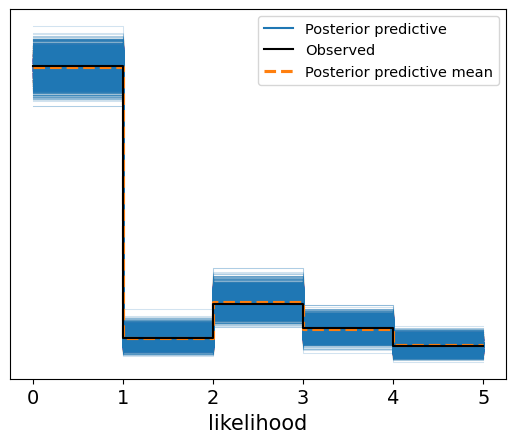

In [13]:
az.plot_ppc(nstL_1.idata);

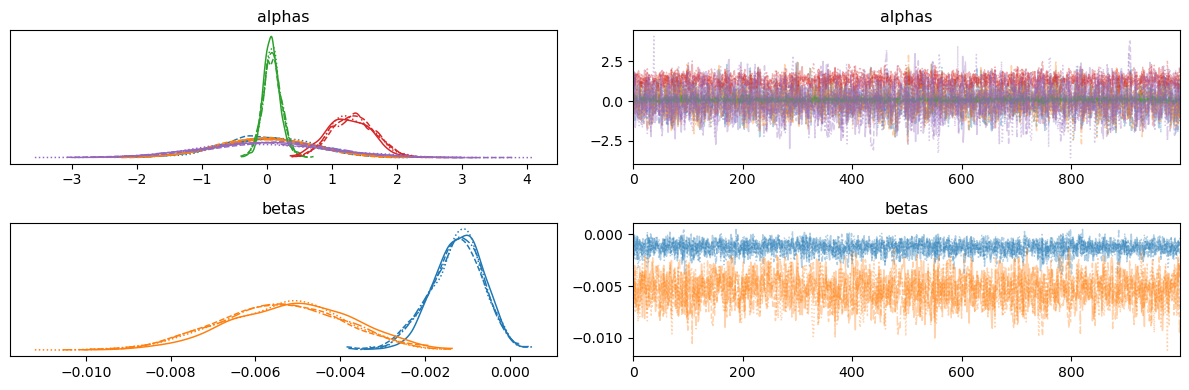

In [14]:
az.plot_trace(nstL_1.idata, var_names=["alphas", "betas"])
plt.tight_layout()

## Two Layer Nesting


In [15]:
## No fixed covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": {"hp": ["hp"], "r": ["gr", "er"]}}

nstL_2 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_2

In [16]:
X, F, y = nstL_2.preprocess_model_data(df, utility_formulas)
print(X.shape)
F

(900, 5, 2)


In [17]:
coords = nstL_2.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': [],
 'nests': ['central', 'room', 'room_hp', 'room_r'],
 'obs': range(0, 900)}

In [18]:
nest_indices = nstL_2.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])},
 'mid': {'room_hp': array([4]), 'room_r': array([2, 3])}}

In [19]:
lambda_lkup = nstL_2.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1, 'room_hp': 2, 'room_r': 3}

In [20]:
nstL_2.make_model(X, F, y)

                 alphas ~ Normal(0, 1)
                  betas ~ Normal(0, 1)
           lambda_nests ~ Beta(2, 2)
                      U ~ Deterministic(f(betas, alphas))
      p_y_given_room_hp ~ Deterministic(f(betas, alphas))
              I_room_hp ~ Deterministic(f(lambda_nests, betas, alphas))
       p_y_given_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
               I_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
              denom_mid ~ Deterministic(f(lambda_nests, betas, alphas))
              P_room_hp ~ Deterministic(f(lambda_nests, betas, alphas))
               P_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
          prod_room_r_m ~ Deterministic(f(lambda_nests, betas, alphas))
         prod_room_hp_m ~ Deterministic(f(betas, alphas, lambda_nests))
        P_room_children ~ Deterministic(f(lambda_nests, betas, alphas))
      p_y_given_central ~ Deterministic(f(lambda_nests, betas, alphas))
              I_central ~ Deterministic(f(lambda_

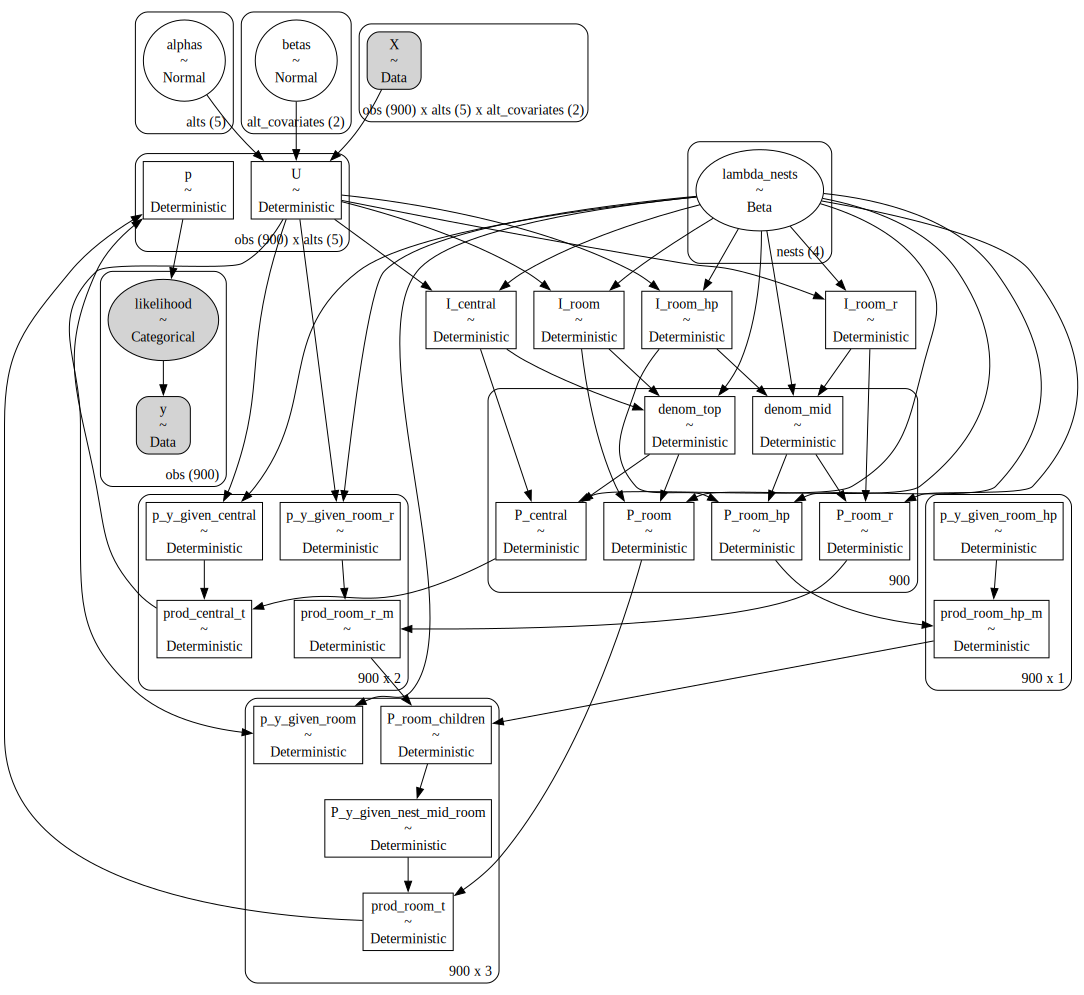

In [21]:
pm.model_to_graphviz(nstL_2.model)

In [22]:
nstL_2.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

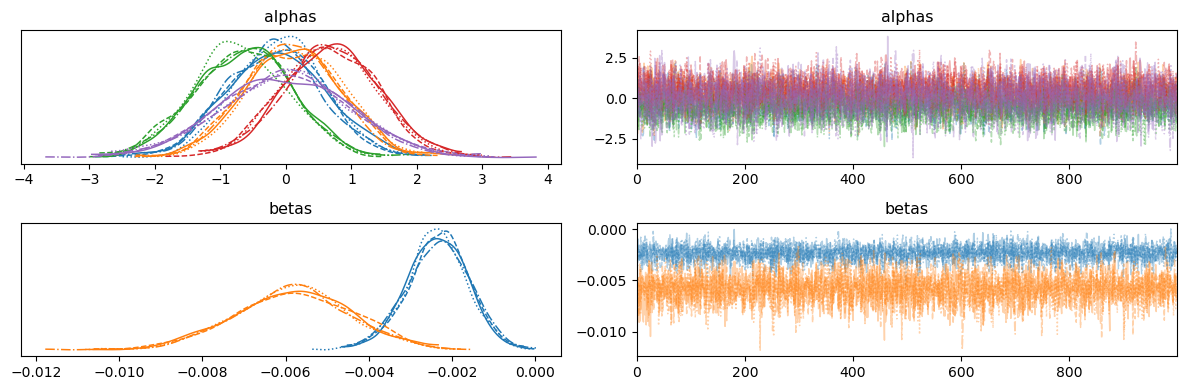

In [23]:
az.plot_trace(nstL_2.idata, var_names=["alphas", "betas"])
plt.tight_layout()

In [24]:
az.summary(nstL_2.idata, var_names=["betas", "alphas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.002,0.001,-0.004,-0.001,0.000,0.000,3698.0,3023.0,1.0
betas[oc],-0.006,0.001,-0.008,-0.003,0.000,0.000,4057.0,2815.0,1.0
alphas[gc],-0.147,0.727,-1.454,1.235,0.015,0.012,2314.0,2487.0,1.0
alphas[ec],0.111,0.721,-1.245,1.387,0.015,0.011,2384.0,2257.0,1.0
alphas[gr],-0.663,0.731,-2.070,0.657,0.015,0.011,2255.0,2492.0,1.0
alphas[er],0.674,0.724,-0.674,2.012,0.015,0.011,2223.0,2638.0,1.0
alphas[hp],-0.014,0.987,-1.901,1.819,0.017,0.019,3390.0,2641.0,1.0


## Fixed Covariates

In [25]:
utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms ",
    "ec ~ ic_ec + oc_ec | income + rooms ",
    "gr ~ ic_gr + oc_gr | income + rooms",
    "er ~ ic_er + oc_er | income + rooms",
    "hp ~ ic_hp + oc_hp | income + rooms",
]

nesting_structure = {"central": ["gc", "ec"], "room": ["hp", "gr", "er"]}


nstL_3 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_3

In [26]:
nstL_3.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [27]:
az.summary(nstL_3.idata, var_names=["alphas", "betas", "betas_fixed"])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],0.100,0.742,-1.207,1.567,0.014,0.012,2938.0,2372.0,1.00
alphas[ec],-0.096,0.756,-1.475,1.375,0.014,0.012,3126.0,2484.0,1.00
alphas[gr],0.461,0.415,-0.308,1.258,0.010,0.007,1834.0,2186.0,1.00
alphas[er],1.399,0.487,0.515,2.346,0.011,0.008,2055.0,2277.0,1.00
alphas[hp],0.027,0.992,-1.828,1.860,0.015,0.016,4645.0,2916.0,1.00
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,3318.0,3170.0,1.00
betas[oc],-0.006,0.001,-0.009,-0.003,0.000,0.000,3262.0,2849.0,1.00
"betas_fixed[gc, income]",0.022,0.156,-0.224,0.256,0.005,0.014,1641.0,917.0,1.01
"betas_fixed[gc, rooms]",0.056,0.199,-0.233,0.386,0.009,0.020,905.0,486.0,1.00
"betas_fixed[ec, income]",0.023,0.158,-0.222,0.255,0.005,0.014,1602.0,889.0,1.00


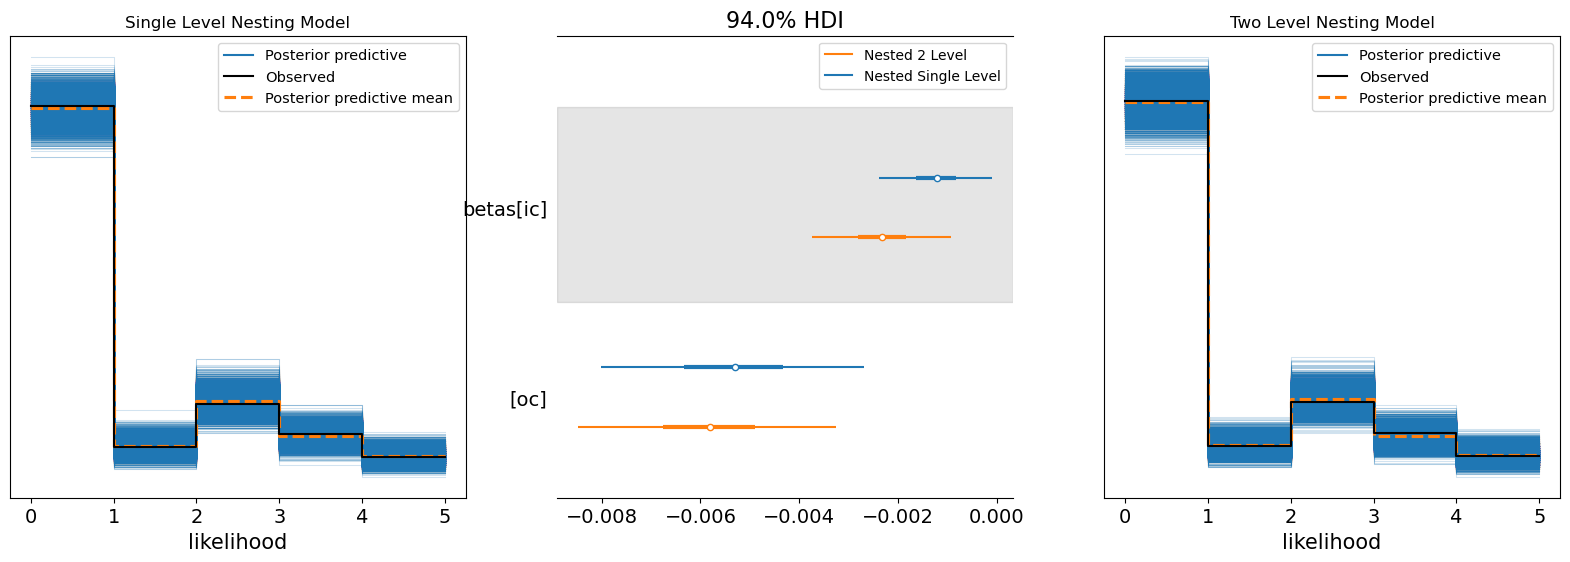

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
az.plot_ppc(nstL_1.idata, ax=axs[0])
axs[0].set_title("Single Level Nesting Model")
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["betas"],
    combined=True,
    ax=axs[1],
    model_names=["Nested Single Level", "Nested 2 Level"],
)
axs[2].set_title("Two Level Nesting Model")
az.plot_ppc(nstL_2.idata, ax=axs[2]);

## Making Interventions



In [29]:
new_policy_df = df.copy()
new_policy_df[["ic_ec", "ic_er"]] = new_policy_df[["ic_ec", "ic_er"]] * 1.5

idata_new_policy_1 = nstL_1.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_2 = nstL_2.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_3 = nstL_3.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_1

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [30]:
change_df_1 = nstL_1.calculate_share_change(nstL_1.idata, nstL_1.intervention_idata)
change_df_1

,policy_share,new_policy_share,relative_change
product,,,
gc,0.634552,0.662410,0.043901
ec,0.072263,0.041118,-0.430997
gr,0.147122,0.181107,0.230993
er,0.089698,0.045661,-0.490942
hp,0.056365,0.069705,0.236661


In [31]:
change_df_2 = nstL_2.calculate_share_change(nstL_2.idata, nstL_2.intervention_idata)
change_df_2

,policy_share,new_policy_share,relative_change
product,,,
gc,0.635044,0.676726,0.065637
ec,0.072466,0.023535,-0.675226
gr,0.148514,0.209391,0.409906
er,0.087452,0.031809,-0.636273
hp,0.056524,0.058540,0.035650


In [32]:
change_df_3 = nstL_3.calculate_share_change(nstL_3.idata, nstL_3.intervention_idata)
change_df_3

,policy_share,new_policy_share,relative_change
product,,,
gc,0.634069,0.663689,0.046715
ec,0.072113,0.037564,-0.479101
gr,0.147339,0.184367,0.251313
er,0.089365,0.042448,-0.525007
hp,0.057114,0.071932,0.259456


## Substitution Patterns

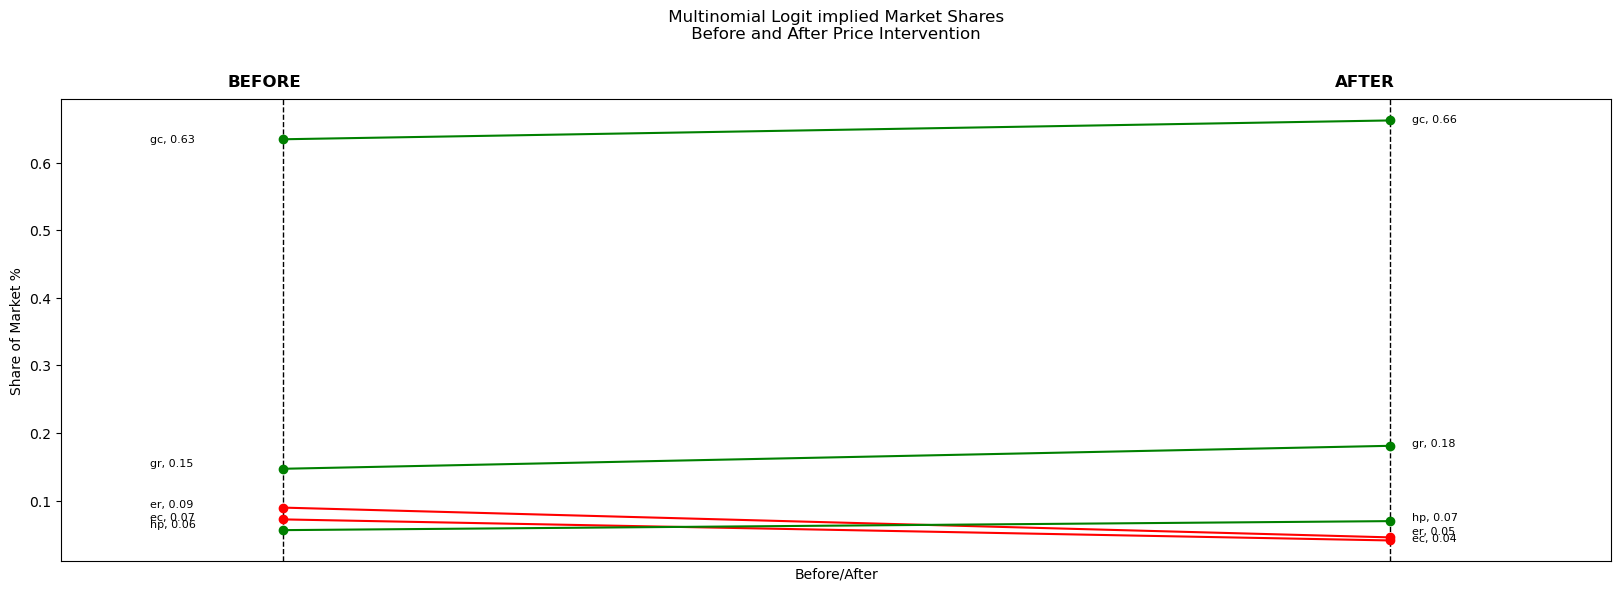

In [33]:
fig = nstL_1.make_change_plot(change_df=change_df_1, figsize=(20, 6))

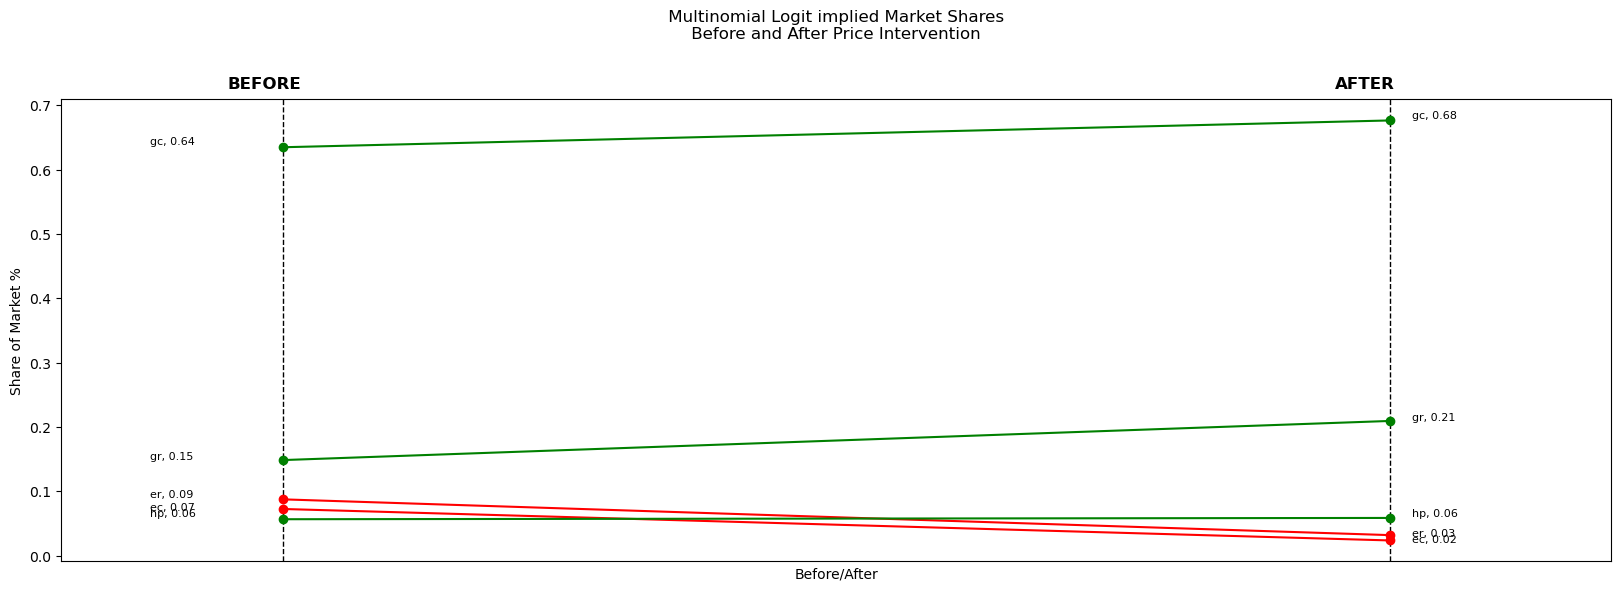

In [34]:
fig = nstL_2.make_change_plot(change_df=change_df_2, figsize=(20, 6))

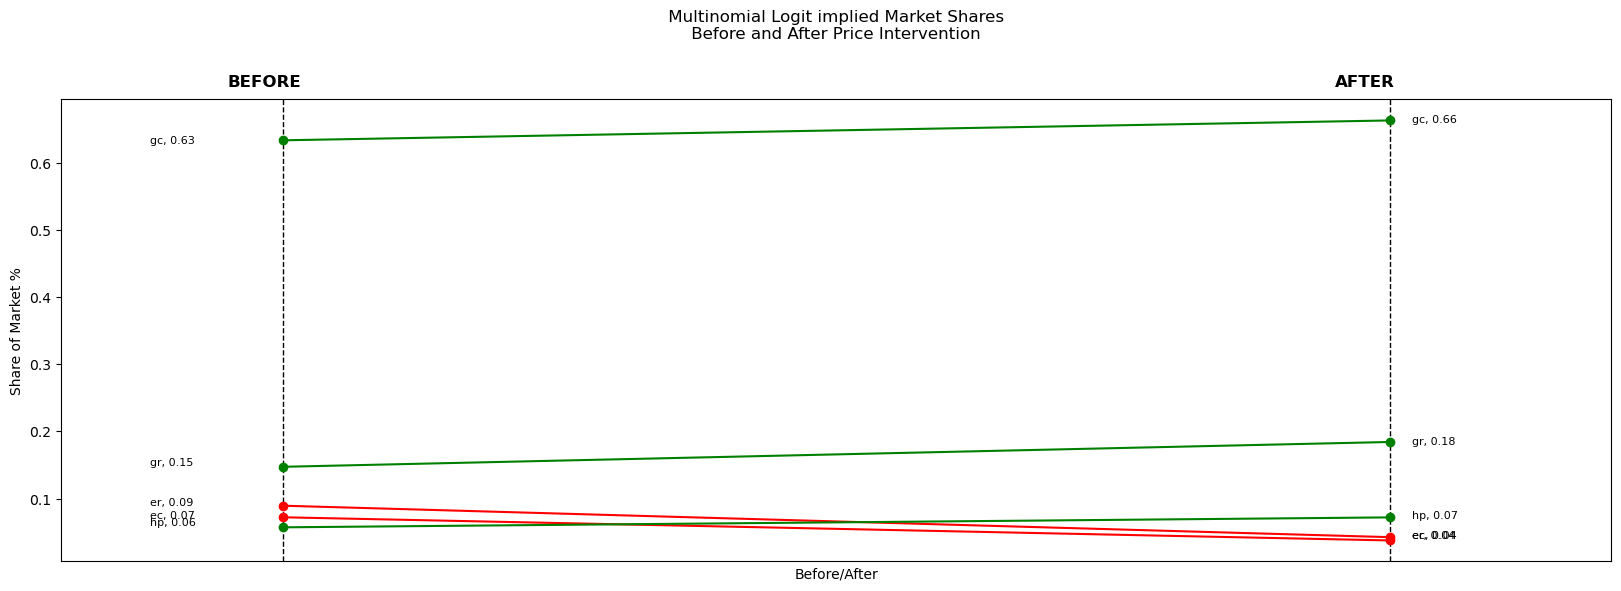

In [35]:
fig = nstL_3.make_change_plot(change_df=change_df_3, figsize=(20, 6))

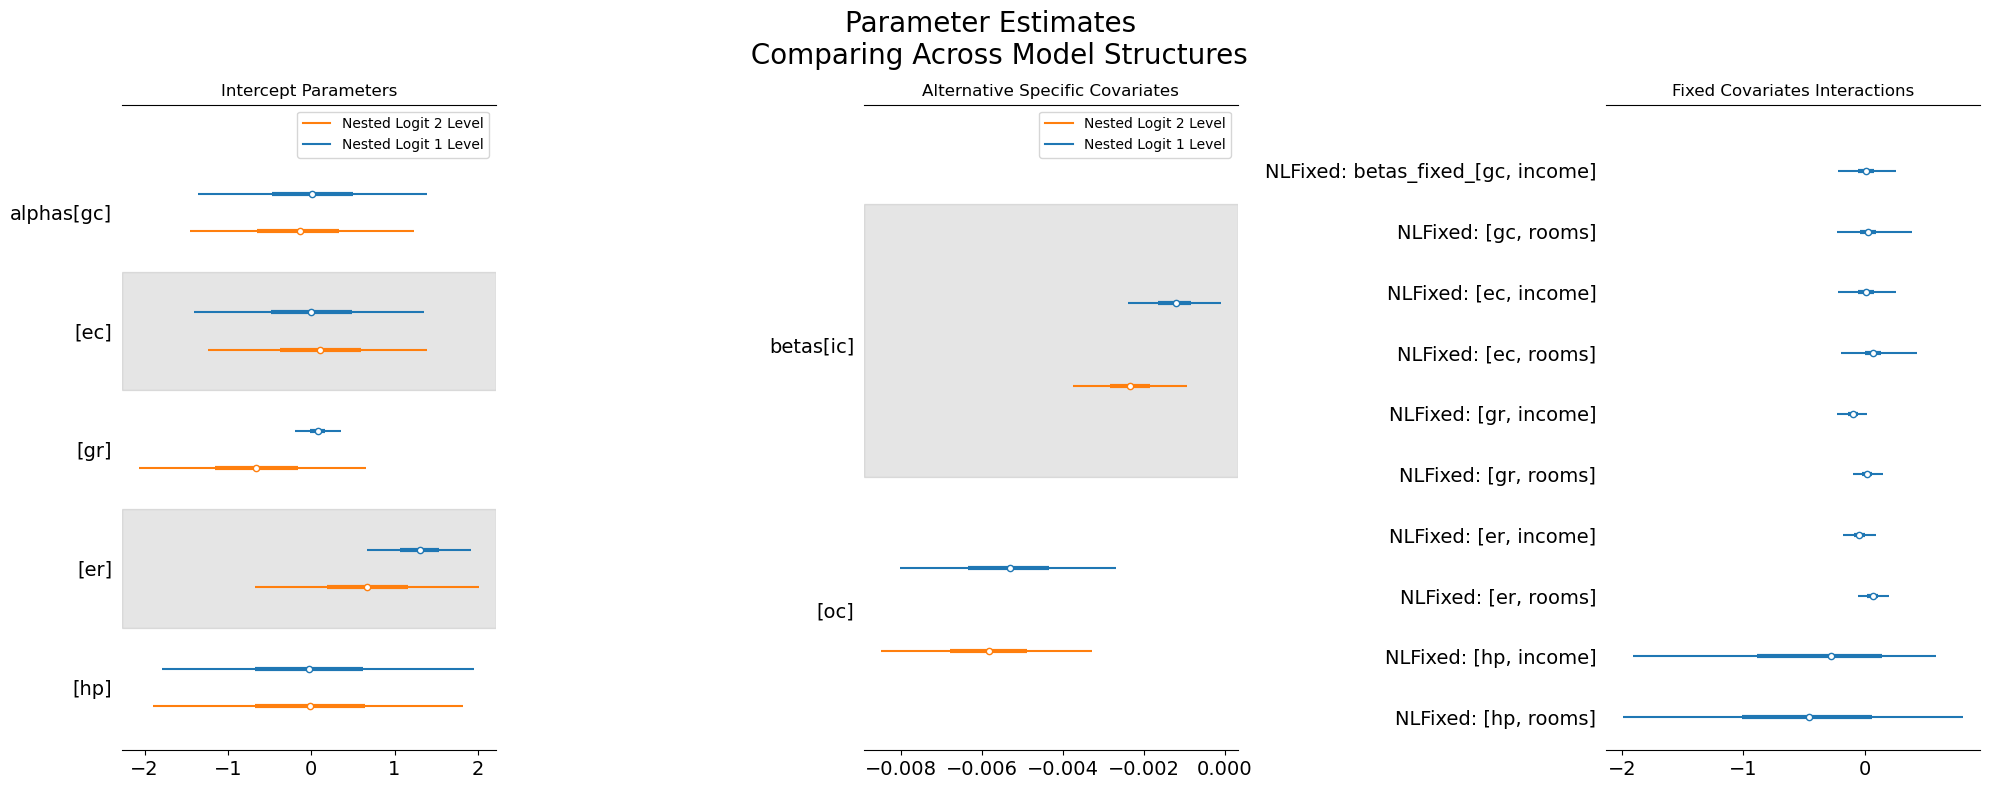

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = axs.flatten()
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["alphas"],
    ax=axs[0],
    combined=True,
    model_names=["Nested Logit 1 Level", "Nested Logit 2 Level"],
)
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["betas"],
    ax=axs[1],
    combined=True,
    model_names=["Nested Logit 1 Level", "Nested Logit 2 Level"],
)
az.plot_forest(
    [nstL_3.idata],
    var_names=["betas_fixed_"],
    ax=axs[2],
    combined=True,
    model_names=["NLFixed"],
)
axs[0].set_title("Intercept Parameters")
axs[1].set_title("Alternative Specific Covariates")
axs[2].set_title("Fixed Covariates Interactions")
plt.suptitle("Parameter Estimates \n Comparing Across Model Structures", fontsize=20)
plt.tight_layout()